In [2]:
from pyabc import History
from pyabc.visualization import plot_kde_matrix, kde_1d
import pyabc.visualization
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv
import random

from tools.DataSimulator import simulate, simulate_all_dates

### Load the study data

In [3]:
# Read the study data into a dictionary
study_data_path = os.path.abspath('data/raw/adult_egg_data_converted.csv')
reader = csv.reader(open(study_data_path, 'r'))
study_data = {}
for row in reader:
   k, v = row
   study_data[k] = float(v)
all_data_path = os.path.abspath('data/raw/all_field_data.csv')
reader = csv.reader(open(all_data_path, 'r'))
all_data = {}
for row in reader:
   k, v = row
   all_data[k] = float(v)

In [4]:
# Limits for the plots (accounts for the inverse log transform that pyabc will do with the results)
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(0, 100), 
              AIAdultSlope=(1, 9),
              AILarvaLD50=(0,100),
              AILarvaSlope=(1, 9))

### Load the completed AMC-SMC run

In [5]:
#retrieve stored run - run ID 1
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "run_5_24.db"))
history = History(db_path)
history.id = 1

In [6]:
t = history.max_t
df, w = history.get_distribution(m=0, t=t)
df["AIAdultLD50"] = df["AIAdultLD50"].copy() *1000
df["AILarvaLD50"] = df["AILarvaLD50"].copy() *1000

### How well does our model predict the field study results?

In [7]:
def draw_posterior(df, w, n=1):
    indices = df.index
    draws = random.choices(population=indices, weights = w, k=n)
    return df.loc[draws,:]

In [120]:
import matplotlib.dates as mdates
import datetime

def posterior_predict(sample_in, ci = 95):
    predictions = np.empty([10,120,len(sample_in.index),5]) # sites x days x sample x response
    sample_dict = sample_in.reset_index(drop=True).to_dict("index")
    vp_inputs = dict()
    for i, (key, pars) in enumerate(sample_dict.items()):
        output = simulate_all_dates(sample_dict[key])
        for j, resp in enumerate(["Adults", "Pupae", "Larvae", "Eggs", "All"]):
            predictions[:,:,i,j] = output[resp]
    return predictions


def get_pp_ci(predictions, ci = 95):
    upper = np.percentile(predictions, 100-(100-ci)/2, axis=2)
    lower = np.percentile(predictions, (100-ci)/2, axis=2)
    median = np.percentile(predictions, 50, axis=2)
    return lower, median, upper


def plot_pop_predictions(response, predictions, field_data, lower, upper, pi=True, save=False, form='median', fig_form = 'png'):
    """ 
    Takes the posterior generation of parameters and 
    plots median posterior and 95% PI colony size vs field data
    """
    resp_index = ["Adults", "Pupae", "Larvae", "Eggs", "All"].index(response)
    START_DATES = ['04/29/2015','04/27/2015', '04/27/2015', '04/28/2015', '04/28/2015', '05/01/2015', '04/30/2015',
               '04/29/2015', '04/28/2015', '04/30/2015']
    DATES_STR = pd.read_csv(os.path.join("data/raw/field_bee_areas.csv")).iloc[:, 15:19] #site x obs date
    DATES_STR.insert(0,'Initial', START_DATES)
    initial_df = pd.read_csv('data/raw/field_initial_conditions.csv', index_col=0)
    best = np.percentile(predictions, 50, axis=2)
    best_label = "Median"
    fig, axs = plt.subplots(5, 2, figsize=(12,14),sharex=True, sharey=True)
    axs = axs.ravel()
    SITES = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    end = datetime.datetime.strptime('08/26/2015', "%m/%d/%Y")  # add a day for initial pop
    days = mdates.DayLocator([10,20])   # every year
    months = mdates.MonthLocator()  # every month
    monthsFmt = mdates.DateFormatter('%B')
    for i, site in enumerate(SITES):
        start = datetime.datetime.strptime(DATES_STR.iloc[i,0], "%m/%d/%Y")
        delta_start = (start - datetime.datetime.strptime('04/27/2015', "%m/%d/%Y")).days
        date_range = [(start + datetime.timedelta(days=x)) for x in range(0, (end - start).days)]
        empirical_pops = field_data[i,:,resp_index]
        median = np.append(empirical_pops[0],best[i,delta_start:,resp_index])
        axs[i].plot(date_range, median, linewidth=3, label=best_label)
        field_dates = [datetime.datetime.strptime(date, "%m/%d/%Y").date() for date in DATES_STR.iloc[i]]
        if pi:
            lower_line = np.append(empirical_pops[0],lower[i,delta_start:,resp_index])
            upper_line = np.append(empirical_pops[0],upper[i,delta_start:, resp_index])
            axs[i].plot(date_range,lower_line, 'k', linestyle=":", linewidth=2, label="95% PI")
            axs[i].plot(date_range,upper_line, 'k', linestyle=":", linewidth=2)
        axs[i].plot_date(field_dates, empirical_pops, label= "Field data")
        exposure_profile = pd.read_csv('data/processed/neonic_profiles/neonic_profile_{}.csv'.format(i+1), index_col=0).iloc[:,1]
        max_ppb = exposure_profile.max() * 10**9
        axs[i].set_title("Site: {}, Max: {:.0f} ppb".format(site, max_ppb))
        axs[i].xaxis.set_major_locator(months)
        axs[i].xaxis.set_major_formatter(monthsFmt)
        axs[i].xaxis.set_minor_locator(days)
        axs[i].set_ylim(bottom=0)
        if i in [0,2,4,6,8]:
            axs[i].set(ylabel=response + " per colony")
    handles, labels = axs[i].get_legend_handles_labels()
    fig.autofmt_xdate()
    fig.tight_layout()
    lgd = plt.legend(handles,labels, loc='center left', bbox_to_anchor=(1, 1), prop={'size': 12})
    if save:
        plt.savefig('figures/posterior_predictions/bee_population/{}.{}'.format(response, fig_form),
                    bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=800)
    plt.show()

    
def convert_data_dict(data_dict):
    """
    Convert the dictionary of study populations by trt and time
    into a 3d array (sites x time x response var). Also add
    a mean for all individuals
    """
    SITES = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    out_stat = np.empty([10, 4, 5])
    for h, h_str in enumerate(["Adults", "Pupae", "Larvae", "Eggs", "All"]): #add in "All" here once it's in field data
        for i, i_str in enumerate(SITES):
            for j, j_str in enumerate(["4","5", "6", "8"]):
                if h_str == "All":
                    key_a = i_str+"_"+j_str+"_{}".format("Adults")
                    key_p = i_str+"_"+j_str+"_{}".format("Pupae")
                    key_l = i_str+"_"+j_str+"_{}".format("Larvae")
                    key_e = i_str+"_"+j_str+"_{}".format("Eggs")
                    out_stat[i,j,h] = data_dict[key_a] + data_dict[key_p] + data_dict[key_l] + data_dict[key_e]
                else:
                    key = i_str+"_"+j_str+"_{}".format(h_str)
                    out_stat[i,j,h] = data_dict[key]
    return out_stat

In [11]:
field_data = convert_data_dict(all_data)
df_ug, w = history.get_distribution(m=0, t=history.max_t) #get distribution ld50 in ug/bee
random.seed(1251)
sample = draw_posterior(df_ug,w,20) #normally 200
predictions = posterior_predict(sample)
lower_pi, median, upper_pi = get_pp_ci(predictions)
np.save("data/processed/predictions.npy", predictions)
np.save("data/processed/lower_pi.npy", lower_pi)
np.save("data/processed/upper_pi.npy", upper_pi)

In [13]:
mean_pars = df_ug.apply(np.average,weights=w, axis=0).to_dict()
mean_sim_STATIC = simulate_all_dates(mean_pars)
np.save("data/processed/mean_sim_STATIC.npy", mean_sim_STATIC)

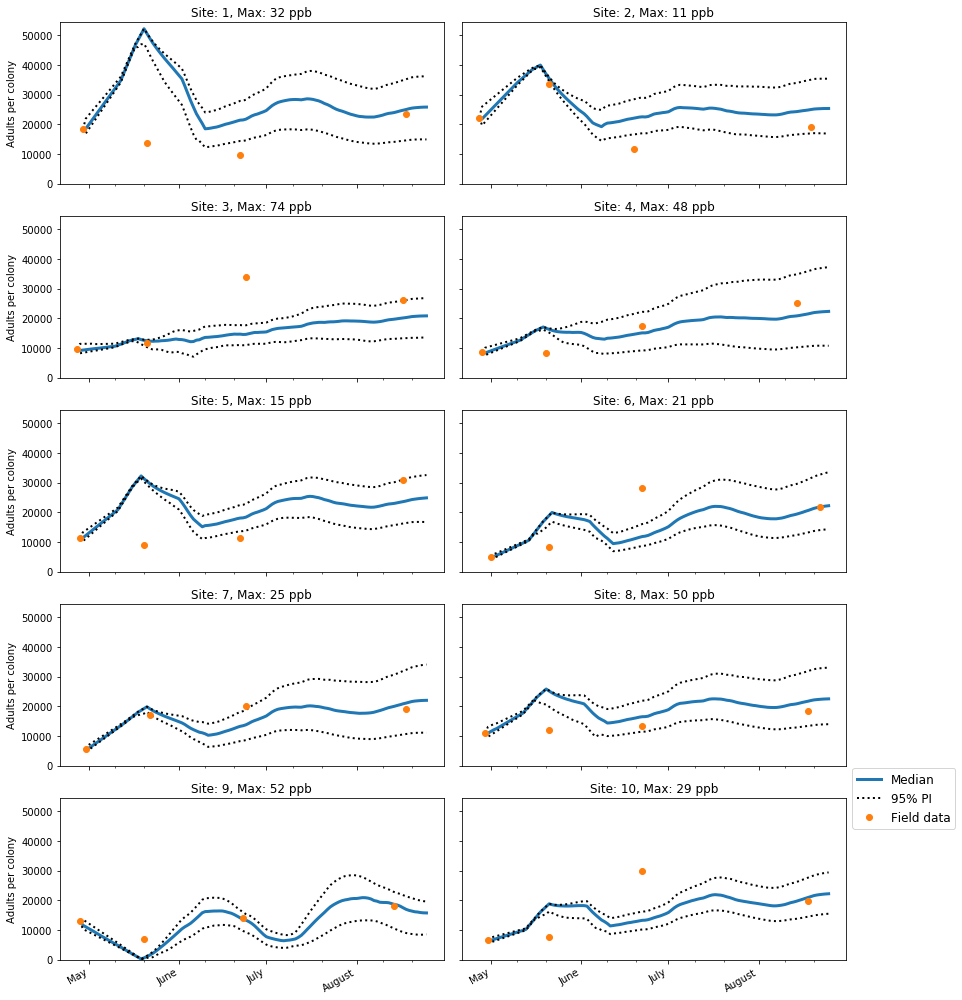

In [122]:
plot_pop_predictions('Adults', predictions, field_data, lower_pi, upper_pi, save = False)

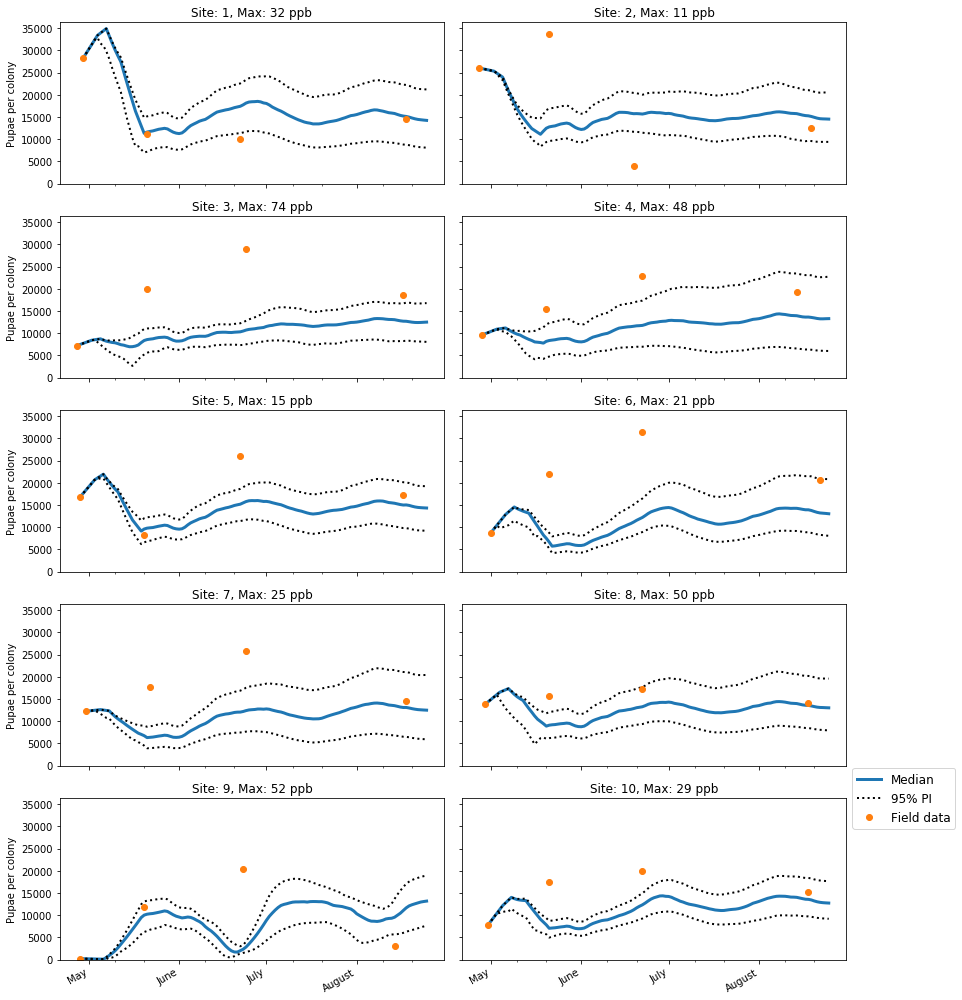

In [123]:
plot_pop_predictions('Pupae', predictions, field_data, lower_pi, upper_pi, save = False)

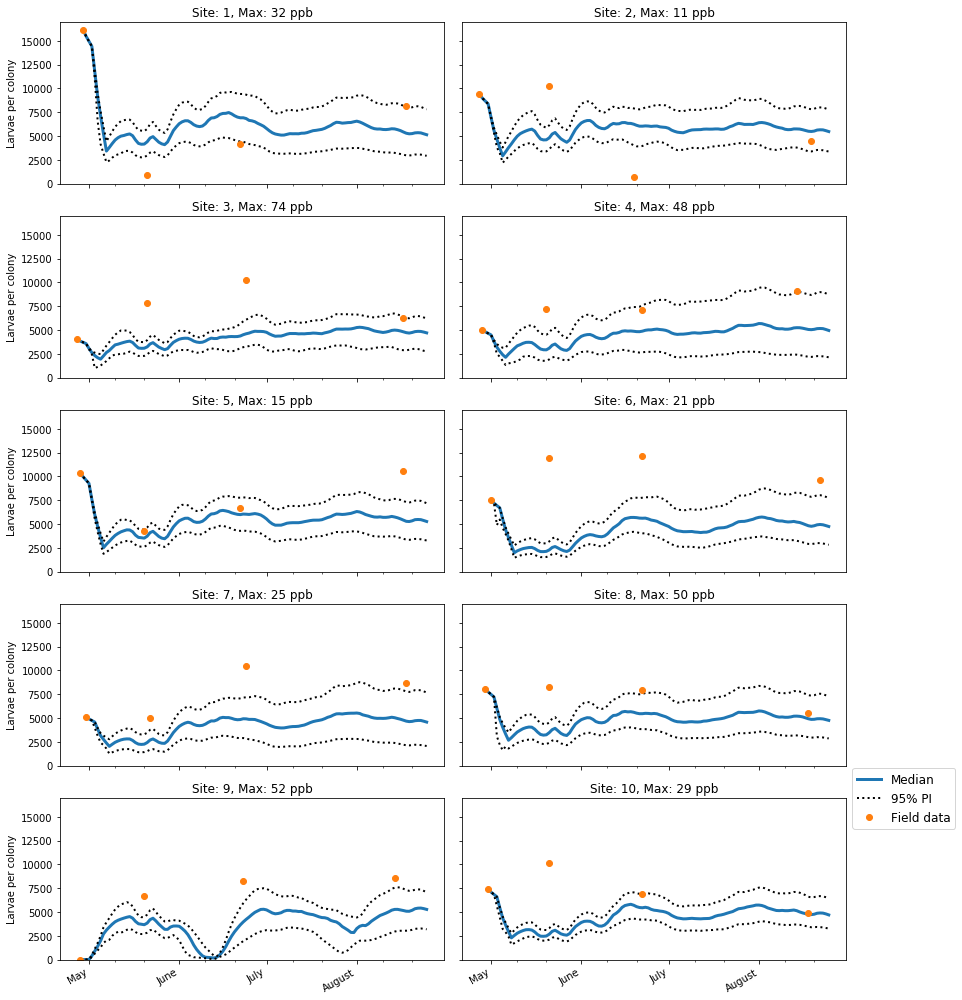

In [124]:
plot_pop_predictions('Larvae', predictions, field_data, lower_pi, upper_pi, save = False)

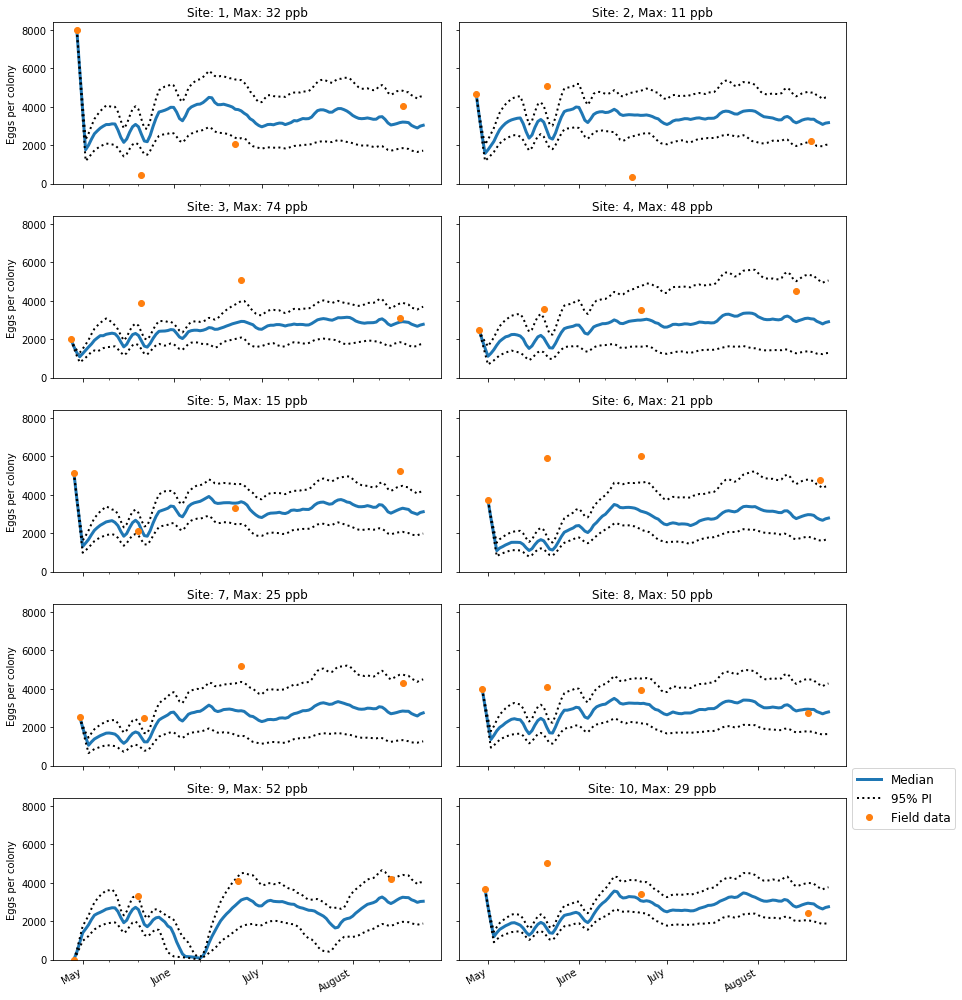

In [125]:
plot_pop_predictions('Eggs', predictions, field_data, lower_pi, upper_pi, save = False)

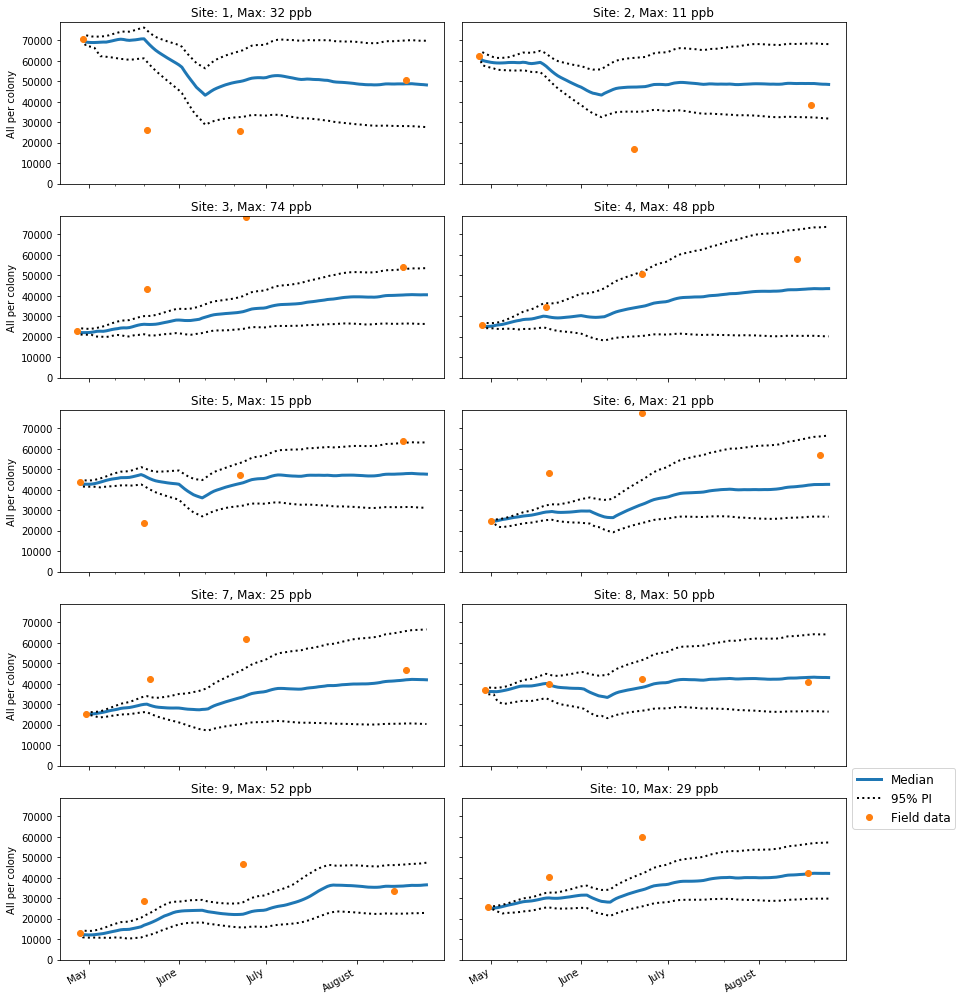

In [126]:
plot_pop_predictions('All', predictions, field_data, lower_pi, upper_pi, save = False)

In [127]:
START_DATES = ['04/29/2015','04/27/2015', '04/27/2015', '04/28/2015', '04/28/2015', '05/01/2015', '04/30/2015',
               '04/29/2015', '04/28/2015', '04/30/2015']
DATES_STR = pd.read_csv(os.path.join("data/raw/field_bee_areas.csv")).iloc[:, 15:19] #site x obs date
DATES_STR.insert(0,'Initial', START_DATES)

In [128]:
start = datetime.datetime.strptime(DATES_STR.iloc[0,0], "%m/%d/%Y")
delta_start = (start - datetime.datetime.strptime('04/27/2015', "%m/%d/%Y")).days
date_range = [(start + datetime.timedelta(days=x)) for x in range(0, (end - start).days)]
delta_start

2

In [129]:
field_data = convert_data_dict(all_data)
field_data

array([[[18302., 28190., 16175.,  8015., 70682.],
        [13697., 11168.,   867.,   429., 26161.],
        [ 9687.,  9975.,  4116.,  2039., 25817.],
        [23622., 14637.,  8160.,  4043., 50462.]],

       [[22233., 26022.,  9387.,  4651., 62293.],
        [33746., 33612., 10254.,  5081., 82693.],
        [11831.,  3903.,   722.,   358., 16814.],
        [19056., 12577.,  4477.,  2218., 38328.]],

       [[ 9647.,  7210.,  4008.,  1986., 22851.],
        [11751., 19842.,  7799.,  3864., 43256.],
        [34004., 29004., 10254.,  5081., 78343.],
        [26024., 18703.,  6246.,  3095., 54068.]],

       [[ 8470.,  9614.,  5031.,  2493., 25608.],
        [ 8231., 15469.,  7245.,  3590., 34535.],
        [17283., 22914.,  7149.,  3542., 50888.],
        [25078., 19300.,  9123.,  4520., 58021.]],

       [[11315., 16806., 10398.,  5152., 43671.],
        [ 9131.,  8132.,  4260.,  2111., 23634.],
        [11434., 25914.,  6643.,  3292., 47283.],
        [30848., 17131., 10615.,  5260., 6

In [130]:
np.percentile(predictions,50, axis=2)[0,:,3]

array([   0. ,    0. , 5895.5, 3782.5, 1762.5, 2001.5, 2315. , 2595.5,
       2749.5, 2890.5, 2991. , 3075. , 3075.5, 3110.5, 3103. , 2796. ,
       2406.5, 2147.5, 2321. , 2676. , 2960.5, 3081.5, 2959. , 2572. ,
       2217. , 2182. , 2507. , 2987.5, 3410. , 3728. , 3771. , 3821.5,
       3888. , 3973.5, 3968.5, 3724. , 3384.5, 3272. , 3516.5, 3850.5,
       3989.5, 4062.5, 4127.5, 4140.5, 4220.5, 4347.5, 4489. , 4468.5,
       4227.5, 4110. , 4110.5, 4135. , 4091. , 4044.5, 3985.5, 3869. ,
       3853. , 3786.5, 3664.5, 3568.5, 3381. , 3288. , 3132.5, 3024.5,
       2956.5, 3010.5, 3076. , 3084.5, 3062. , 3115.5, 3152. , 3142. ,
       3072. , 3123. , 3180. , 3280.5, 3264.5, 3328. , 3388.5, 3374. ,
       3385. , 3466. , 3647. , 3799.5, 3842.5, 3839.5, 3789.5, 3716.5,
       3721. , 3829. , 3906. , 3907. , 3852. , 3779. , 3675. , 3547. ,
       3464. , 3399. , 3380.5, 3392. , 3418.5, 3387.5, 3349. , 3355. ,
       3468.5, 3485.5, 3348. , 3157.5, 3053. , 3082.5, 3123. , 3174.5,
      